<a href="https://colab.research.google.com/github/brit228/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/DS_Unit_2_Sprint_Challenge_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [0]:
import pandas as pd

cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Income']

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=cols)
df_test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", names=cols, skiprows=[0])

In [47]:
print(df.isna().sum())
print(df_test.isna().sum())
print()
print(df.shape[0], "Training dataset - correct length")
print(df_test.shape[0], "Testing dataset - correct length")

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Income            0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Income            0
dtype: int64

32561 Training dataset - correct length
16281 Testing dataset - correct length


In [0]:
for c in df:
  if df[c].dtype == "object":
    v = pd.get_dummies(df[c])
    for d in v:
      df["{}:{}".format(c,d.strip())] = v[d]
    df = df.drop(columns=[c], axis=1)
    
for c in df_test:
  if df_test[c].dtype == "object":
    v = pd.get_dummies(df_test[c])
    for d in v:
      if c == "Income" and "{}:{}".format(c,d[:-1].strip()) in list(df):
        df_test["{}:{}".format(c,d[:-1].strip())] = v[d]
      elif "{}:{}".format(c,d.strip()) in list(df):
        df_test["{}:{}".format(c,d.strip())] = v[d]
    df_test = df_test.drop(columns=[c], axis=1)
    
df = df.drop(columns=["Income:<=50K"]+[c for c in df if c not in list(df_test)], axis=1)
df_test = df_test.drop(columns=["Income:<=50K"], axis=1)

y_col = "Income:>50K"
cols = [c for c in df if c != y_col]

mean = df[cols].mean()
std = df[cols].std()
df[cols] = (df[cols]-mean)/std
df_test[cols] = (df_test[cols]-mean)/std

In [49]:
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass:?,workclass:Federal-gov,workclass:Local-gov,workclass:Never-worked,...,native-country:Puerto-Rico,native-country:Scotland,native-country:South,native-country:Taiwan,native-country:Thailand,native-country:Trinadad&Tobago,native-country:United-States,native-country:Vietnam,native-country:Yugoslavia,Income:>50K
0,0.030670,-1.063594,1.134721,0.148451,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
1,0.837096,-1.008692,1.134721,-0.145918,-0.216656,-2.222119,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
2,-0.042641,0.245075,-0.420053,-0.145918,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
3,1.057031,0.425795,-1.197440,-0.145918,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
4,-0.775756,1.408154,1.134721,-0.145918,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,-2.932903,-0.045408,-0.022172,0


In [50]:
df_test.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass:?,workclass:Federal-gov,workclass:Local-gov,workclass:Never-worked,...,native-country:Puerto-Rico,native-country:Scotland,native-country:South,native-country:Taiwan,native-country:Thailand,native-country:Trinadad&Tobago,native-country:United-States,native-country:Vietnam,native-country:Yugoslavia,Income:>50K
0,-0.995690,0.350769,-1.197440,-0.145918,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
1,-0.042641,-0.947081,-0.420053,-0.145918,-0.216656,0.774456,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0
2,-0.775756,1.394341,0.746028,-0.145918,-0.216656,-0.035429,-0.244446,-0.174292,3.815318,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,1
3,0.397227,-0.279066,-0.031360,0.895070,-0.216656,-0.035429,-0.244446,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,1
4,-1.508871,-0.817446,-0.031360,-0.145918,-0.216656,-0.845314,4.090750,-0.174292,-0.262093,-0.014664,...,-0.059273,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340949,-0.045408,-0.022172,0


## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

import warnings
warnings.filterwarnings("ignore")

X = df[[x for x in df if x != y_col]]
y = df[y_col]
X_test = df_test[[x for x in df_test if x != y_col]]
y_test = df_test[y_col]

C_values = [np.power(10.0,x) for x in range(-5,2+1,1)]
C_grid = {'C': C_values}
n_folds = 3
logReg = LogisticRegression(penalty='l1', random_state=7)
grid_logReg = GridSearchCV(logReg, C_grid, cv=n_folds, refit=True)
grid_logReg.fit(X,y)

log_reg = grid_logReg.best_estimator_
print(log_reg.score(X_test, y_test))
print()
df_res = pd.DataFrame(columns=["feature", "coefficient"])
df_res.loc[0] = ["Intercept", log_reg.intercept_[0]]
for i,c in enumerate([c for c in df if c != y_col]):
  df_res.loc[i+1] = [c, log_reg.coef_[0][i]]
df_res = df_res.sort_values(by="coefficient")

0.8530188563356059



In [52]:
for i in range(len(df_res)):
  row = df_res.iloc[i]
  print("{:40s}\t{: 12.8f}".format(row["feature"], row["coefficient"]))

Intercept                               	 -2.04008597
relationship:Own-child                  	 -0.34259880
education:Preschool                     	 -0.27072073
occupation:Other-service                	 -0.24078944
marital-status:Never-married            	 -0.22212281
occupation:Priv-house-serv              	 -0.17521666
occupation:Farming-fishing              	 -0.16828871
occupation:Handlers-cleaners            	 -0.13097940
sex:Female                              	 -0.11091193
relationship:Other-relative             	 -0.09481123
workclass:Self-emp-not-inc              	 -0.08067308
native-country:Columbia                 	 -0.07614608
workclass:?                             	 -0.06634703
occupation:Machine-op-inspct            	 -0.06591559
native-country:Dominican-Republic       	 -0.06327120
native-country:Mexico                   	 -0.05970457
education:Assoc-acdm                    	 -0.05488155
workclass:Without-pay                   	 -0.05331869
race:Amer-Indian-Eskimo     

{'mean_fit_time': array([ 0.14152519,  0.1431187 ,  0.22590613,  1.22706906,  3.22949076,
       23.66246621, 23.97518802,  4.09335629]), 'std_fit_time': array([4.66104556e-03, 1.73263275e-03, 1.97474305e-02, 3.62961785e-01,
       5.22075140e-01, 2.56076361e+00, 7.59379369e+00, 1.09888166e-01]), 'mean_score_time': array([0.00493979, 0.0047098 , 0.00433707, 0.00453186, 0.00446041,
       0.00460951, 0.00465655, 0.00448728]), 'std_score_time': array([1.31323412e-04, 7.45286800e-05, 2.20471321e-04, 6.31300704e-05,
       1.19115846e-04, 6.42891719e-05, 1.43826819e-04, 4.60256965e-06]), 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}], 'split0_test_score': array([0.75916713, 0.75916713, 0.82052699, 0.84733739, 0.8484

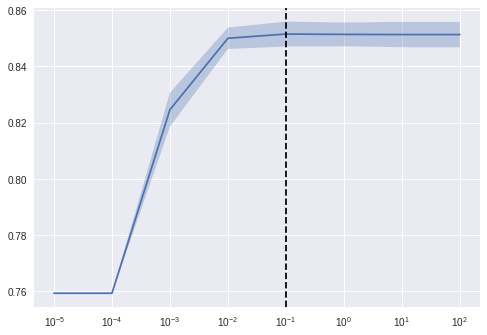

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
print(grid_logReg.cv_results_)
ax.plot([x["C"] for x in grid_logReg.cv_results_["params"]], grid_logReg.cv_results_["mean_test_score"])
ax.fill_between([x["C"] for x in grid_logReg.cv_results_["params"]],
                [grid_logReg.cv_results_["mean_test_score"][i] - 1.96 * grid_logReg.cv_results_["std_test_score"][i] for i in range(len(grid_logReg.cv_results_["std_test_score"]))],
                [grid_logReg.cv_results_["mean_test_score"][i] + 1.96 * grid_logReg.cv_results_["std_test_score"][i] for i in range(len(grid_logReg.cv_results_["std_test_score"]))],
               alpha=0.3)
ax.axvline([x["C"] for x in grid_logReg.cv_results_["params"]][list(grid_logReg.cv_results_["mean_test_score"]).index(grid_logReg.cv_results_["mean_test_score"].max())],
          linestyle="--", color="#000000")
ax.set_xscale('log')
plt.show()

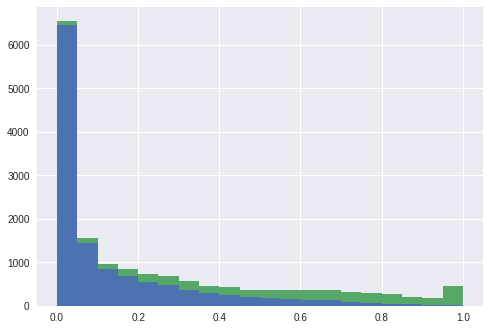

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([log_reg.predict_proba(X_test)[:,1][y_test == 0], log_reg.predict_proba(X_test)[:,1][y_test == 1]], stacked=True, bins=20)
plt.show()

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?

    - capital-gain
    - marital-status:Married-civ-spouse
    - education-num

2. What are 3 features negatively correlated with income above 50k?

    - relationship:Own-child
    - education:Preschool
    - occupation:Other-service
    
  The previous 2 questions were based on the coefficients of the best generated model, which is derived from the standardization of the features in the model. The coefficients can be used to as they represent standard weighting of the features.

3. Overall, how well does the model explain the data and what insights do you derive from it?

  - The best model has an accuracy of 85.27%, meaning that 85.27% of the time, it accurately predicts the actual result. There are some interesting results as well, including the 5 top occipations:
    * occupation:Exec-managerial
    * occupation:Prof-specialty
    * occupation:Tech-support
    * occupation:Sales
    * occupation:Protective-serv

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

## Ridge Regression

You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.
    
  * This can be used as an ordinary linear regression may not work due to low numbers of samples to create a model from. Ridge regression can compensate for this lack of data.


## Quantile Regression

You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.

  * As ordinary linear regression will generalize for the whole domain of grades, wheighting must be applied to the regression through quantile regresssion in order to focus on the bottom tier of grades.


## Survival Analysis

You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.

  * Survival analysis generally applies to end of life, but can be generalized to apply to any event to create the probability over time. In this case, the probability would refer to a company not releasing a product at that time.